In [21]:
#Your code goes here
#%%
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import math
import sys
from pandas.plotting import table
from sklearn.preprocessing import StandardScaler
import scipy.fftpack as fp
from sklearn.model_selection import train_test_split
# from mnist import MNIST


#one hot encoder 
def kfolds(X,Y,k):
    n = X.shape[0]
    m_k = round(n/k)
    data = np.hstack((X,Y))
    K_folds = []

    for i in range(k):
        if i < k-1:
            K_folds.append(data[m_k*i:m_k*(i+1),:])
        else :
            K_folds.append(data[m_k*i:,:])
    return K_folds


def confusion_matrix(y_true,y_pred,onehotencoded=True):
    if(onehotencoded==True):
        m,k = y_true.shape
        return np.matmul(y_true.T,y_pred).astype(int)

def normalized_confusion_marix(y_true,y_pred):
    confmatrix = confusion_matrix(y_true,y_pred)
    confmatrix = (confmatrix/np.sum(confmatrix,axis=1).reshape((confmatrix.shape[0],1))).astype(float)
    return confmatrix

def precesion_recall(y_true,y_pred):
    #precesion = TP/TP+FP
    #recall = TP/TP+FN
    confmatrix  = confusion_matrix(y_true,y_pred)
    row_sum_confmatrix = np.sum(confmatrix,axis=0).tolist()
    column_sum_confmatrix= np.sum(confmatrix,axis=1).tolist()
    precesion = []
    recall = []
    tp = []
    for i in range(confmatrix.shape[0]):
        for j in range(confmatrix.shape[1]):
            if(i==j):
                tp.append(confmatrix[i][j])
                precesion.append(round(float(confmatrix[i][j]/row_sum_confmatrix[i]),4))
                recall.append(round(float(confmatrix[i][j]/column_sum_confmatrix[i]),4))
    fp = np.subtract(np.array(row_sum_confmatrix), np.array(tp)).tolist()
    fn =  np.subtract(np.array(column_sum_confmatrix), np.array(tp)).tolist()
    return precesion,recall,tp,fp,fn


def micro_scores(y_true,y_pred):
    # avg_prec = float(np.nansum(precesion)/len(precesion))
    # avg_rec = float(np.nansum(recall)/len(recall))
    # f1score = 2*(avg_prec*avg_rec)/(avg_prec+avg_rec)
    _,_,tp,fp,fn = precesion_recall(y_true,y_pred)
    tp_sum = sum(tp)
    tp_fp_sum = sum(tp)+sum(fp)
    tp_fn_sum = tp_sum + sum(fn)
    micro_avg_prec = round(float(tp_sum/tp_fp_sum),3)
    micro_avg_rec = round(float(tp_sum/tp_fn_sum),3)
    micro_avg_f1 = round((2*micro_avg_prec*micro_avg_rec)/(micro_avg_prec+micro_avg_rec),3)
    return micro_avg_f1,micro_avg_prec,micro_avg_rec

def macro_scores(y_true,y_pred):
    precesion,recall,_,_,_ = precesion_recall(y_true,y_pred)
    prec_avg =round(float(np.nansum(precesion)/(len(precesion))),3)
    rec_avg = round(float(np.nansum(recall)/len(recall)),3)
    macro_f1 = round((2*prec_avg*rec_avg)/(prec_avg+rec_avg),3)
    return macro_f1,prec_avg,rec_avg

def save_image(df,table_name):
    print(df)
    fig, ax = plt.subplots(figsize=(20, 2)) # set size frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
    tabla = table(ax, df, loc='upper right', colWidths=[0.1]*len(df.columns))  # where df is your data frame
    tabla.auto_set_font_size(False) # Activate set fontsize manually
    tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
    tabla.scale(1.3, 1.3) # change size table
    plt.savefig(table_name)

def fft_image_data(trainx):
    #shape of trainx = m,n
    ## Functions to go from image to frequency-image and back
    im2freq = lambda data: fp.rfft(fp.rfft(data, axis=0),
                                   axis=1)
    freq2im = lambda f: fp.irfft(fp.irfft(f, axis=1),
                                 axis=0)

    ## Read in data file and transform
    for i in range(trainx.shape[0]):
        curr_img = trainx[i,:].reshape((32,32))
        data = curr_img

        freq = im2freq(data)
        back = freq2im(freq)
        assert(np.allclose(data, back))

        ## Helper functions to rescale a frequency-image to [0, 255] and save
        remmax = lambda x: x/x.max()
        remmin = lambda x: x - np.amin(x, axis=(0,1), keepdims=True)
        touint8 = lambda x: (remmax(remmin(x))*(256-1e-4)).astype(int)
        trainx[i,:] = touint8(freq).reshape((1,1024))
    return trainx

def onehotEncoder(array,k_class):
    if(type(array)==list):
        array = np.array(array)
    assert len(array.shape)==1
    onehotencoded = np.zeros((array.shape[0],k_class))
    array = array.reshape((array.shape[0],))
    for i in range(array.shape[0]):
        onehotencoded[i,array[i]-1] = 1
    return onehotencoded

def sigmoid_func(X):
        return 1/(1+np.exp(-X))

def softmax_stable(y):
    y_pred_max = -1*np.max(y,axis=1,keepdims=True)
    y = np.exp(y+y_pred_max)
    column_wise_sum = np.sum(y,axis=1,keepdims=True)
    return (y/column_wise_sum)

def relu_func(X):
        X = np.where(X<0,0,X)
        return X

def relu_derivative(x):
    x = np.where(x<0,0,1)
    return x
    
def tanh_func(X):
        return np.tanh(X)

def tanh_prime(X):
    return 1-np.power(tanh_func(X),2)

def sigmoid_prime(X):
    return sigmoid_func(X)*(1-sigmoid_func(X))

def softmax_prime(y):
    return softmax_stable(y)*(1-softmax_stable(y))

class neuron_layer:
    def __init__(self,inputs_neurons,number_of_neurons):
        self.inputs_neurons=inputs_neurons
        self.number_of_neurons = number_of_neurons
        self.dropout_mask=None
        self.batch_normalized_layer=None
        self.set_weights(np.sqrt(2/inputs_neurons)*np.random.uniform(-1,1,(inputs_neurons,number_of_neurons)))
        self.set_bias(np.random.uniform(-1,1,(1,number_of_neurons)))

    def set_weights(self,weights):
        self.weights = weights
    
    def get_weights(self):
        return self.weights
    
    def set_bias(self,bias):
        self.bias = bias
    
    def get_bias(self):
        return self.bias

    def layer_output(self,inputs):
        self.layer_output_z = np.matmul(inputs,self.weights) +self.bias
    
    def activate_layer(self,sigmoid=False,relu=False,tanh=False,softmax=False):
        self.activate_a=None
        if(sigmoid==True):
            if(self.batch_normalized_layer is not None):
                self.activate_a = sigmoid_func(self.batch_normalized_layer)
            else:
                self.activate_a = sigmoid_func(self.layer_output_z)
            # if(isoutput==False):
            #     self.activate_a = np.hstack((np.ones((self.activate_a.shape[0],1)),self.activate_a))
        if(relu==True):
            if(self.batch_normalized_layer is None):
                self.activate_a = relu_func(self.layer_output_z)
            else:
                self.activate_a = relu_func(self.batch_normalized_layer)
            # if(isoutput==False):
            #     self.activate_a = np.hstack((np.ones((self.activate_a.shape[0],1)),self.activate_a))
        if(tanh==True):
            if(self.batch_normalized_layer is not None):
                self.activate_a = tanh_func(self.batch_normalized_layer)
            else:
                self.activate_a = tanh_func(self.layer_output_z)
            # if(isoutput==False):
            #     self.activate_a = np.hstack((np.ones((self.activate_a.shape[0],1)),self.activate_a))
        if(softmax==True):
            if(self.batch_normalized_layer is not None):
                self.activate_a = softmax_stable(self.batch_normalized_layer)
            else:
                self.activate_a = softmax_stable(self.layer_output_z)
    



    


class Neural_a:

    def __init__(self,trainX,trainY,n_output_neurons,n_hl_neurons,ismulti=False,activation_func="sigmoid",drop_prob=0,isBatchNormalize=False):
        assert type(n_hl_neurons)==list
        # assert (len(trainY.shape))==2
        self.trainX = trainX
        self.trainY = trainY
        self.batch_normalize=isBatchNormalize
        self.drop_prob=drop_prob
        #activation function for hidden layer, wheather sigmoid or relu or tanh
        self.activation_func = activation_func

        #numbe of hidden layers
        self.n_layers = len(n_hl_neurons)

        #number of units in output layer
        self.n_output_neurons = n_output_neurons

        #whether classification is multiclass or binary
        self.ismulti = ismulti

        #to create architecture of network
        self.create_architechure(n_hl_neurons)
    
    def create_architechure(self,neurons_list):
        if(self.ismulti==True):
            assert self.n_output_neurons > 1
        '''
        neurons list is a list containing number of neurons in each hidden layer
        length of list should be equal to number of hidden layers
        it should not have input layer and output layer shape
        '''
        assert type(neurons_list)==list

        #first hidden layer
        self.layers = [neuron_layer(self.trainX.shape[1],neurons_list[0])]

        #adding hidden layer upto output layer
        self.layers =self.layers + [neuron_layer(neurons_list[i-1],neurons_list[i]) for i in range(1,len(neurons_list))]

        #output layer which is last layer
        self.layers = self.layers+ [neuron_layer(neurons_list[-1],self.n_output_neurons)]

    def forward_propagate(self,x,istraining=True):

        #Z1 value
        self.layers[0].layer_output(x)

        #batchnormalzing Z1 value before activation
        if(self.batch_normalize==True):
            self.layers[0].batch_normalized_layer = self.batch_normalization(self.layers[0].layer_output_z)

        for i in range(1,len(self.layers)):

            if(self.activation_func =="sigmoid"):
                #applying activation function
                self.layers[i-1].activate_layer(sigmoid=True)

                #calculating drop out mask ith drop_prob probability
                self.layers[i-1].dropout_mask = self.dropout(self.layers[i-1].activate_a,self.drop_prob)
            if(self.activation_func =='relu'):
                self.layers[i-1].activate_layer(relu=True)
                self.layers[i-1].dropout_mask = self.dropout(self.layers[i-1].activate_a,self.drop_prob)
            if(self.activation_func =='tanh'):
                self.layers[i-1].activate_layer(tanh=True)
                self.layers[i-1].dropout_mask = self.dropout(self.layers[i-1].activate_a,self.drop_prob)
            
            #feeding next hidden layer
            '''
            in training phase dropout applied but in test phase it should not
            '''
            if(istraining==True):
                self.layers[i].layer_output(self.layers[i-1].dropout_mask)

                #batch normalization of Z values of this hidden layer
                if(self.batch_normalize==True):
                    self.layers[i].batch_normalized_layer = self.batch_normalization(self.layers[i].layer_output_z)
            if(istraining==False):
                self.layers[i].layer_output(self.layers[i-1].activate_a)
                if(self.batch_normalize==True):
                    self.layers[i].batch_normalized_layer = self.batch_normalization(self.layers[i].layer_output_z)

        #activation of last layer 
        if(self.ismulti==True):
            self.layers[-1].activate_layer(softmax=True)
        else:
            self.layers[-1].activate_layer(sigmoid=True)
        return self.layers[-1].activate_a

    def Binary_cross_entropy_loss(self,y,outputs):
        term1 = y*np.log(outputs[:,0])
        term2 = (1-y)*np.log(1-outputs[:,0])
        return -(1/y.shape[0])*np.sum(term1+term2)
    
    def multiclass_ce_loss(self,y,outputs):
        return -1*(np.sum(y*np.log(outputs+1e-6))/y.shape[0])
    
    def multiclass_ce_derivative(self,y):
        assert self.layers[-1].activate_a.shape ==y.shape
        return (self.layers[-1].activate_a - y)/y.shape[0]


    #derivative of binary cross entropy cost with respect to Z values
    def cost_derivative(self,trainy):
        #shape of y --> m*2
        #shape of t --> m*1
        y  = self.layers[-1].activate_a 
        t = trainy
        return (y-t)/trainy.shape[0]   #dl/dy
    
    def dropout(self,X,drop_prob):
        assert 0<=drop_prob<=1
        if(drop_prob==1):
            return np.zeros_like(X)
        mask = np.random.uniform(0,1,X.shape) > drop_prob
        return (mask*X)/(1.0-drop_prob)
        
    
    def mini_batch(self,batch_size):
        number_of_mini_batch=math.floor(self.trainX.shape[0]/batch_size)
        self.batches_x = []
        self.batches_y =[]
        for i in range(number_of_mini_batch):
            self.batches_x.append(self.trainX[i*batch_size:(i+1)*batch_size,:])
            self.batches_y.append(self.trainY[i*batch_size:(i+1)*batch_size,:])
        if(number_of_mini_batch*batch_size<self.trainX.shape[0]):
            self.batches_x.append(self.trainX[number_of_mini_batch*batch_size:,:])
            self.batches_y.append(self.trainY[number_of_mini_batch*batch_size:,:])
        
        return self.batches_x,self.batches_y
        
        
    def batch_normalization(self,X):
        # scaler = StandardScaler()
        # X  = scaler.fit_transform(X)
        X_mu = np.mean(X,axis=0,keepdims=True)
        X_var = np.var(X,axis=0,keepdims=True)
        X = (X-X_mu)/np.sqrt(X_var+1e-6)
        return X

    def accuracy(self,y,outputs):
        '''
        y and outputs are of size m,k where k is number of classes
        '''
        y =np.argmax(y,axis=1)
        outputs = np.argmax(outputs,axis=1)
        acc = [1 if x==y else 0 for (x,y) in zip(y,outputs)]
        return float(np.sum(acc)/len(acc))
    
    def predictions(self,x):
        pred_outputs = self.forward_propagate(x)
        return pred_outputs

    
    def back_propagate(self,x,y):

        #initializing all weights to zeros
        back_prop_weights_updates = [np.zeros((w.get_weights().shape)) for w in self.layers]
        back_prop_bias_updates = [np.zeros(b.get_bias().shape) for b in self.layers]

        #feed forward 
        self.forward_propagate(x)

        #delta for output layer
        if(self.ismulti==True):
            delta = self.multiclass_ce_derivative(y)
        else:
            delta = self.cost_derivative(y)  #dl/dz

        #dw and db for output layer
        back_prop_weights_updates[-1] = np.matmul(self.layers[-2].activate_a.T,delta)
        back_prop_bias_updates[-1] = np.sum(delta,axis=0,keepdims=True)

        for i in range(1,len(self.layers)):
            curr_layer = self.layers[-(i+1)]
            prev_layer = self.layers[-i]

            #calculation of derivative of activation function
            if(self.activation_func=='sigmoid'):
                sp = curr_layer.activate_a*(1-curr_layer.activate_a)
            if(self.activation_func=='relu'):
                sp = relu_derivative(curr_layer.layer_output_z)
            if(self.activation_func =='tanh'):
                sp = tanh_prime(curr_layer.layer_output_z)

            #delta calculation for hidden layers
            delta = np.matmul(delta,prev_layer.get_weights().T)*sp*(curr_layer.dropout_mask/(1.0-self.drop_prob))
            if(i==(len(self.layers)-1)):
                activations = x.T
            else:
                activations = self.layers[-(i+2)].activate_a.T
            # print(back_prop_weights_updates[-(i+1)].shape)
            back_prop_weights_updates[-(i+1)]= np.dot(activations,delta)
            back_prop_bias_updates[-(i+1)]= np.sum(delta,axis=0,keepdims=True)
        
        return back_prop_weights_updates,back_prop_bias_updates

    def train_network(self,valx,valy,learning_rate,iterations,n_batches,adaptive=False):
        self.mini_batch(n_batches)
        x,y = self.batches_x,self.batches_y
        k = len(x)
        train_cost_history=[]
        val_cost_history=[]
        train_acc_hist=[]
        val_acc_hist=[]
        epochs=0
        for i in range(iterations):
            # weights = [np.zeros(w.get_weights().shape) for w in self.layers]
            # biases =  [np.zeros(w.get_bias().shape) for w in self.layers]
            mini_batchx,mini_batchy = x[i%k],y[i%k]
            dw,db = self.back_propagate(mini_batchx,mini_batchy)

            if(adaptive==False):
                for j,w in enumerate(dw):
                    new_weights = self.layers[j].get_weights() - (learning_rate)*w
                    self.layers[j].set_weights(new_weights)
                for j,b in enumerate(db):
                    new_biases = self.layers[j].get_bias() - (learning_rate)*b
                    self.layers[j].set_bias(new_biases)
            
            if(adaptive==True):
                for j,w in enumerate(dw):
                    new_weights = self.layers[j].get_weights() - (learning_rate/(np.sqrt(i+1)))*w
                    self.layers[j].set_weights(new_weights)
                for j,b in enumerate(db):
                    new_biases = self.layers[j].get_bias() - (learning_rate/(np.sqrt(i+1)))*b
                    self.layers[j].set_bias(new_biases)
            
            if(i%len(x)==0):
                epochs=epochs+1
                outputs = self.forward_propagate(self.trainX,istraining=False)
                val_outputs = self.forward_propagate(valx,istraining=False)
                train_cost =self.multiclass_ce_loss(self.trainY,outputs)
                val_cost  = self.multiclass_ce_loss(valy,val_outputs)
                train_cost_history.append(train_cost)
                val_cost_history.append(val_cost)
    
                train_acc = self.accuracy(self.trainY,outputs)
                train_acc_hist.append(train_acc)
                val_acc  =self.accuracy(valy,val_outputs)
                val_acc_hist.append(val_acc)
                print("Epoch no.: "+ str(epochs)+"  train_cost:"+str(train_cost)+"  val_cost:"+str(val_cost)+" train_acc:"+str(train_acc)+"  val_acc:"+str(val_acc))
            # ou = sigmoid_func(self.forward_propagate(self.trainX))
            # print(self.Binary_cross_entropy_loss(self.trainY,ou))
        return self.layers[-1].activate_a,train_cost_history,val_cost_history,train_acc_hist,val_acc_hist

In [2]:
scaler = StandardScaler()
input_file = 'train.csv'
test_file = 'test_X.csv'

df = pd.read_csv(input_file,header=None,error_bad_lines = False)
df_test = pd.read_csv(test_file,header=None,error_bad_lines = False)    
last_column = len(df.columns)-1
last_column_test = len(df_test.columns)-1
trainy = df[last_column].values.reshape((df.shape[0],))
trainx  = df.drop([last_column],axis=1).values
trainy=trainy+1
trainy = onehotEncoder(trainy,10)

#fourier transform -> in frequency domain
trainx = trainx/255.0
trainx = scaler.fit_transform(trainx)
trainx,valx,trainy,valy = train_test_split(trainx,trainy,test_size=0.2,random_state=42)

#fourier transform - in frequency domain
testx = df_test.drop([last_column_test],axis=1).values
testx= testx/255.0
testx = scaler.fit_transform(testx)


neural_net = Neural_a(trainx,trainy,10,[517],ismulti=True,activation_func='relu',drop_prob=0.5,isBatchNormalize=False)
_,train_cost_hist,val_cost_hist,train_acc_hist,val_acc_hist = neural_net.train_network(valx,valy,0.01,12000,100)
    # outputs = neural_net.forward_propagate(testx,istraining=False)
    # outputs = np.argmax(outputs,axis=1).tolist()

# weights_file = weights_file[:-4]+str(iterations)+weights_file[-4:

# with open(output_file,"w") as f:

#     for o in outputs:
#                 f.write(str(o))
#                 f.write("\n")

#%%


Epoch no.: 1  train_cost:2.6083809835822844  val_cost:2.6049528220799454 train_acc:0.11125  val_acc:0.105
Epoch no.: 2  train_cost:2.0587787006235003  val_cost:2.088701489562659 train_acc:0.2665625  val_acc:0.24775
Epoch no.: 3  train_cost:1.9969672184672218  val_cost:2.051061399321168 train_acc:0.291  val_acc:0.27175
Epoch no.: 4  train_cost:1.9496872618187062  val_cost:1.9999509312743295 train_acc:0.3100625  val_acc:0.28425
Epoch no.: 5  train_cost:1.9274394145044866  val_cost:2.0174996300631034 train_acc:0.320625  val_acc:0.30075
Epoch no.: 6  train_cost:1.8985948139024418  val_cost:1.998207366550344 train_acc:0.3280625  val_acc:0.30225
Epoch no.: 7  train_cost:1.8760554769922801  val_cost:1.983253902383151 train_acc:0.336875  val_acc:0.29975
Epoch no.: 8  train_cost:1.8605135364225929  val_cost:1.9737389360253048 train_acc:0.3415  val_acc:0.3175
Epoch no.: 9  train_cost:1.8506447748157187  val_cost:1.9965498351330597 train_acc:0.3476875  val_acc:0.30075
Epoch no.: 10  train_cost:1.

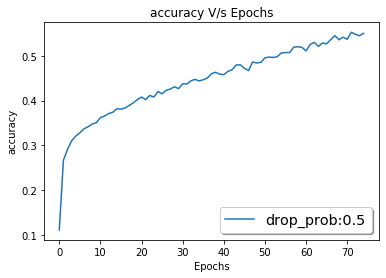

In [20]:
fig,ax = plt.subplots()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("accuracy V/s Epochs")
ax.plot(train_acc_hist,label="drop_prob:"+str(0.5))
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.savefig("train_accuracy_dp05_12000.png")